In [1]:
%load_ext lab_black

import numpy as np
from matplotlib import pyplot as plt

### 1. Stochastic Gradient Descent para encontrar el máximo de una función

#### Implementar en Python un algoritmo basado en Stochastic Gradient Descent para encontrar numéricamente el mínimo de $f(x) = -(x - 2)^{2} + 3$

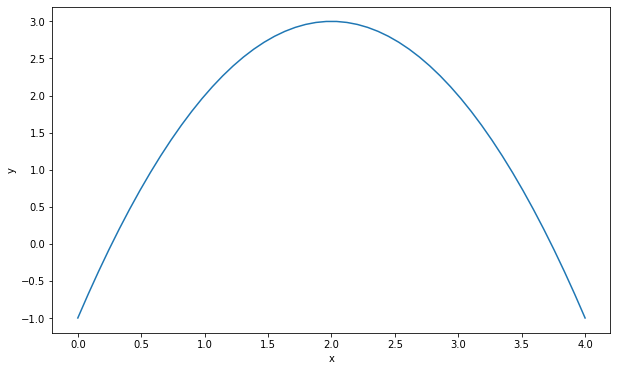

In [2]:
n_samples = 50

f = lambda x: -((x - 2) ** 2) + 3

x = np.linspace(0, 4, n_samples)
y = f(x)

plt.figure(figsize=(10, 6))
plt.plot(x, y)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [3]:
def find_max(start_x, lr, epochs, early_stop=False):
    x = start_x
    history = []
    for epoch in range(epochs):
        grad = -2 * (x - 2)
        if early_stop and np.absolute(grad) < early_stop:
            print(f"Early stop at epoch: {epoch}")
            break
        x += lr * grad
        history.append(x)
    return x, history


max, history = find_max(
    start_x=0.1,
    lr=0.01,
    epochs=10000,
    early_stop=0.01,
)
print(f"El máximo de y se da en x={max:.4f} y={f(max):.4f}")

Early stop at epoch: 295
El máximo de y se da en x=1.9951 y=3.0000


#### ¿Cuál es el máximo valor que encontró el algoritmo y para qué valor de x?

El máximo valor de la función es $y = 3$ y se da en el cuando $x = 2$

#### ¿En qué momento detuviste la búsqueda y por qué?

En este caso la busqueda se detuvo después de $295$ iteraciones ya que el valor del gradiente era menor a $0.01$ (valor de *early stop*). Este valor fue elegido de manera arbitraria pero puede ser mayor o menor según los requisitos del problema.

#### ¿Cómo inicializamos los valores random del algoritmo y cómo afectan la convergencia? 

En general los valores random se inicializan con funciones de generación aleatoria que proveen librearias como numpy. En este caso se utilizo un valor de 0.1 para la inicialización para obtener un early stop luego de una cantidad de epochs determinados.

A continuación vemos cuantas epochs son necesarias para converger al aumentar la distancia entre el valor de $x$ que genera del máximo $y$ y el $x$ inicial

Early stop at epoch: 263
Early stop at epoch: 366
Early stop at epoch: 490
Early stop at epoch: 605
Early stop at epoch: 719
Early stop at epoch: 833


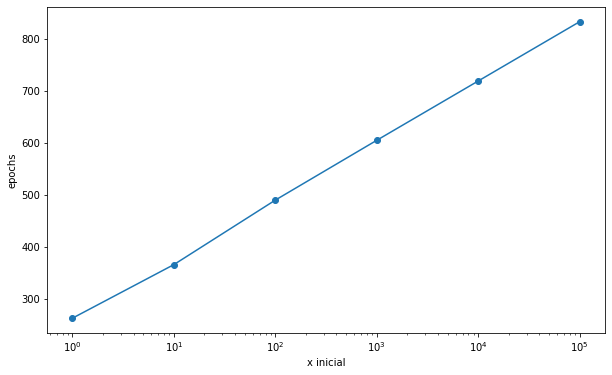

In [4]:
start_x = []
taken_epochs = []

for i in range(6):
    max, history = find_max(
        start_x=10**i,
        lr=0.01,
        epochs=10000,
        early_stop=0.01,
    )
    start_x.append(10**i)
    taken_epochs.append(len(history))

plt.figure(figsize=(10, 6))
plt.scatter(start_x, taken_epochs)
plt.plot(start_x, taken_epochs)
plt.xlabel("x inicial")
plt.ylabel("epochs")
plt.xscale("log")
plt.show()

Puede verse que a medida que el $x$ inicial se aleja de $2$, son necesarias más epochs para converger.

#### ¿Cuáles son los hiper parámetros del algoritmo?

Los hiperparámetros son:
- *learning rate*
- *epochs*
- *early stop*
- *x inicial*

### 2. Mini-Batch Gradient Descent para entrenar un modelo cuadrático

#### Crear un dataset sintético con 10,000 muestras a partir de la siguiente expresión (donde $x$ es la feature que toma valores entre 0 y 4, e $y$ es la salida): 

#### $y = -(x - 2)^{2} + 3 + 0.2 sin(16x)$

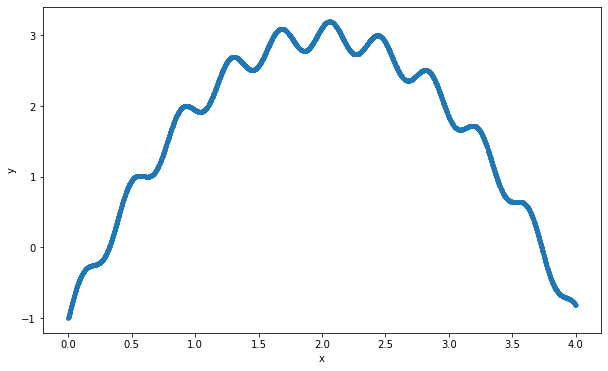

In [5]:
n_samples = 10000

f = lambda x: -((x - 2) ** 2) + 3 + 0.2 * np.sin(16 * x)

x = np.random.uniform(low=0, high=4, size=n_samples)
y = f(x)

plt.figure(figsize=(10, 6))
plt.scatter(x, y, marker=".")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

#### Suponer que se tiene un modelo, tal que la relación entre la salida y la entrada está dada por la ecuación presentada a continuación.

#### $\hat{y} = w_{1}x^{2} + w_{2}x + w_{3}$

#### Suponiendo que se va a utilizar mini-batch SGD para encontrar los valores óptimos de los pesos $w_{1}$, $w_{2}$ y $w_{3}$ tal que minimizan el ECM (Error Cuadrático Medio) (el ECM es la función de costo para este problema), ¿cuál sería la regla de actualización de cada parámetro?. 

Dada la función de costo, el ECM, se define su derivada respecto de $\hat{y}$.

$J(y, \hat{y}) = (y - \hat{y})^{2}$

$\frac{\partial J}{\partial \hat{y}} = -2(y - \hat{y}) $

Se calcula la derivada parcial de $\frac{\partial J}{\partial w_{i}}$ para cada valor de $w$ para obtener la regla de actualización de cada parámetro.

$\frac{\partial J}{\partial w_{1}} = \frac{\partial J}{\partial \hat{y}} \cdot \frac{\partial \hat{y}}{\partial w_{1}} = -2(y - \hat{y}) \cdot x^{2}$

$\frac{\partial J}{\partial w_{2}} = \frac{\partial J}{\partial \hat{y}} \cdot \frac{\partial \hat{y}}{\partial w_{2}} = -2(y - \hat{y}) \cdot x$

$\frac{\partial J}{\partial w_{3}} = \frac{\partial J}{\partial \hat{y}} \cdot \frac{\partial \hat{y}}{\partial w_{3}} = -2(y - \hat{y})$

Agregando el learning rate $\alpha$ la regla de actualizaion para cada $w$ es la siguiente:

$w_{1}:= w_{1} - \alpha \cdot (-2(y - \hat{y}) \cdot x^{2})$

$w_{2}:= w_{2} - \alpha \cdot (-2(y - \hat{y}) \cdot x)$

$w_{3}:= w_{3} - \alpha \cdot (-2(y - \hat{y}))$

#### Implementar el algoritmo en Python (usar mini-batch), encontrar los valores óptimos para $w_{1}$, $w_{2}$ y $w_{3}$ y reportar la evolución del ECM con el número de epochs.




In [6]:
class CustomModel:
    def initializeParameters(self):
        W1, W2, W3 = np.random.rand(3)
        self.params = (W1, W2, W3)

    def fit(self, x, y, epochs, learning_rate, batch=1):
        self.initializeParameters()

        history = []
        n = x.shape[0]

        for epoch in range(epochs):
            for batch_start in range(0, n, batch):
                batch_end = min(batch_start + batch, n)
                self.forwardPropagation(
                    x[batch_start:batch_end],
                    y[batch_start:batch_end],
                )
                self.backwardPropagation(
                    x[batch_start:batch_end],
                    y[batch_start:batch_end],
                    learning_rate,
                )
            history.append(self.cost.mean())
            print(f"Epoch {epoch+1}: cost={self.cost.mean():.4f}")

        return history

    def forwardPropagation(self, x, y):
        W1, W2, W3 = self.params
        self.y_hat = W1 * x**2 + W2 * x + W3
        self.cost = (y - self.y_hat) ** 2

    def backwardPropagation(self, x, y, learning_rate):
        W1, W2, W3 = self.params

        dy_hat = -2 * (y - self.y_hat)
        dW1 = dy_hat * x**2
        dW2 = dy_hat * x
        dW3 = dy_hat

        self.params = (
            W1 - learning_rate * dW1.mean(),
            W2 - learning_rate * dW2.mean(),
            W3 - learning_rate * dW3.mean(),
        )

    def predict(self, x):
        W1, W2, W3 = self.params
        return W1 * x**2 + W2 * x + W3

Probamos el modelo con puntos equidistantes en el intervalo $[0, 4]$ y un batch size=1000

Epoch 1: cost=2.3695
Epoch 2: cost=1.8658
Epoch 3: cost=1.7662
Epoch 4: cost=1.7207
Epoch 5: cost=1.6859
Epoch 6: cost=1.6542
Epoch 7: cost=1.6240
Epoch 8: cost=1.5948
Epoch 9: cost=1.5663
Epoch 10: cost=1.5386
Epoch 11: cost=1.5117
Epoch 12: cost=1.4854
Epoch 13: cost=1.4598
Epoch 14: cost=1.4348
Epoch 15: cost=1.4105
Epoch 16: cost=1.3868
Epoch 17: cost=1.3637
Epoch 18: cost=1.3412
Epoch 19: cost=1.3193
Epoch 20: cost=1.2979


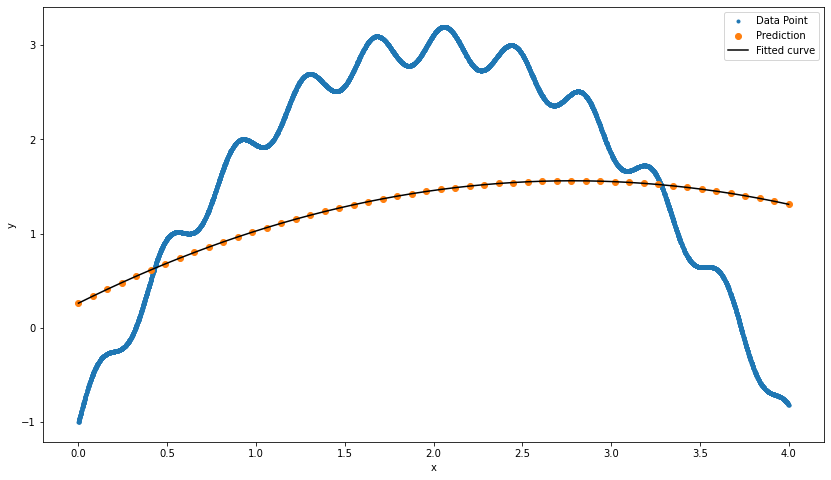

In [7]:
custom_model = CustomModel()
custom_model.fit(x, y, 20, 0.001, batch=1000)

x_test = np.linspace(0, 4, 50)
y_pred = custom_model.predict(x_test)

plt.figure(figsize=(14, 8))
plt.scatter(x, y, label="Data Point", marker=".")
plt.scatter(x_test, y_pred, label="Prediction")
plt.plot(x_test, y_pred, color="k", label="Fitted curve")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

Probamos el modelo con puntos equidistantes en el intervalo $[0, 4]$ y un batch size=1

Epoch 1: cost=0.1361
Epoch 2: cost=0.0396
Epoch 3: cost=0.0185
Epoch 4: cost=0.0126
Epoch 5: cost=0.0108
Epoch 6: cost=0.0101
Epoch 7: cost=0.0099
Epoch 8: cost=0.0098
Epoch 9: cost=0.0098
Epoch 10: cost=0.0097
Epoch 11: cost=0.0097
Epoch 12: cost=0.0097
Epoch 13: cost=0.0097
Epoch 14: cost=0.0097
Epoch 15: cost=0.0097
Epoch 16: cost=0.0097
Epoch 17: cost=0.0097
Epoch 18: cost=0.0097
Epoch 19: cost=0.0097
Epoch 20: cost=0.0097


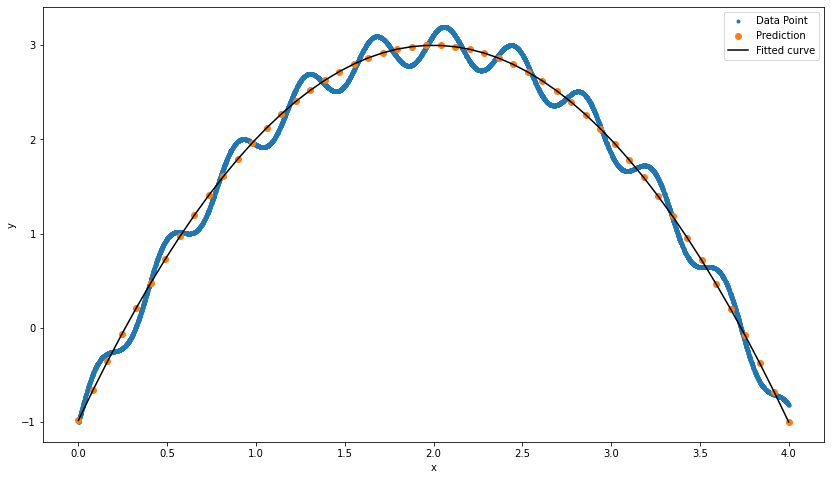

In [8]:
custom_model = CustomModel()
custom_model.fit(x, y, 20, 0.001, batch=1)

x_test = np.linspace(0, 4, 50)
y_pred = custom_model.predict(x_test)

plt.figure(figsize=(14, 8))
plt.scatter(x, y, label="Data Point", marker=".")
plt.scatter(x_test, y_pred, label="Prediction")
plt.plot(x_test, y_pred, color="k", label="Fitted curve")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()